In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.densenet import DenseNet201
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type

## Load in the Dataset

In [2]:
X_train = np.load("/Users/somiseta/isic2018/221_221/221_221_train.npy")

In [3]:
y_train = np.load("/Users/somiseta/isic2018/221_221/train_labels.npy")

In [4]:
X_val = np.load("/Users/somiseta/isic2018/221_221/221_221_val.npy")

In [5]:
y_val = np.load("/Users/somiseta/isic2018/221_221/val_labels.npy")

In [6]:
X_train.shape, X_val.shape

((8111, 221, 221, 3), (902, 221, 221, 3))

In [7]:
y_train.shape, y_val.shape

((8111,), (902,))

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [9]:
y_train.shape, y_val.shape

((8111, 7), (902, 7))

## Load the Pretrained Model

In [10]:
pre_trained_model = DenseNet201(input_shape=(221, 221, 3), include_top=False, weights="imagenet")

In [11]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_1
zero_padding2d_1
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_2
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3

conv4_block40_1_relu
conv4_block40_2_conv
conv4_block40_concat
conv4_block41_0_bn
conv4_block41_0_relu
conv4_block41_1_conv
conv4_block41_1_bn
conv4_block41_1_relu
conv4_block41_2_conv
conv4_block41_concat
conv4_block42_0_bn
conv4_block42_0_relu
conv4_block42_1_conv
conv4_block42_1_bn
conv4_block42_1_relu
conv4_block42_2_conv
conv4_block42_concat
conv4_block43_0_bn
conv4_block43_0_relu
conv4_block43_1_conv
conv4_block43_1_bn
conv4_block43_1_relu
conv4_block43_2_conv
conv4_block43_concat
conv4_block44_0_bn
conv4_block44_0_relu
conv4_block44_1_conv
conv4_block44_1_bn
conv4_block44_1_relu
conv4_block44_2_conv
conv4_block44_concat
conv4_block45_0_bn
conv4_block45_0_relu
conv4_block45_1_conv
conv4_block45_1_bn
conv4_block45_1_relu
conv4_block45_2_conv
conv4_block45_concat
conv4_block46_0_bn
conv4_block46_0_relu
conv4_block46_1_conv
conv4_block46_1_bn
conv4_block46_1_relu
conv4_block46_2_conv
conv4_block46_concat
conv4_block47_0_bn
conv4_block47_0_relu
conv4_block47_1_conv
conv4_block47_1_bn

In [12]:
last_layer = pre_trained_model.get_layer('bn')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 1920)


## Define the Model

In [13]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Adding dropout
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 221, 221, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 227, 227, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 111, 111, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 111, 111, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

## Training

### Feature Extraction

In [15]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [16]:
batch_size = 16
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

Epoch 1/3
506/506 [==============================] - 224s 442ms/step - loss: 1.3856 - acc: 0.6336 - val_loss: 0.8674 - val_acc: 0.6931
Epoch 2/3
506/506 [==============================] - 173s 343ms/step - loss: 0.8712 - acc: 0.6962 - val_loss: 0.7504 - val_acc: 0.7248
Epoch 3/3
506/506 [==============================] - 174s 345ms/step - loss: 0.7818 - acc: 0.7236 - val_loss: 0.7109 - val_acc: 0.7259


### Fine Tuning

In [17]:
pre_trained_model.layers[481].name

'conv5_block1_0_bn'

In [18]:
for layer in pre_trained_model.layers[481:]:
    layer.trainable = True

In [19]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 221, 221, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 227, 227, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 111, 111, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 111, 111, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [22]:
batch_size = 16
epochs = 30
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Epoch 1/30
506/506 [==============================] - 223s 442ms/step - loss: 0.6952 - acc: 0.7507 - val_loss: 0.5536 - val_acc: 0.8007
Epoch 2/30
506/506 [==============================] - 181s 357ms/step - loss: 0.5802 - acc: 0.7866 - val_loss: 0.5214 - val_acc: 0.7905
Epoch 3/30
506/506 [==============================] - 181s 359ms/step - loss: 0.5113 - acc: 0.8150 - val_loss: 0.4804 - val_acc: 0.8097
Epoch 4/30
506/506 [==============================] - 181s 358ms/step - loss: 0.4569 - acc: 0.8379 - val_loss: 0.4947 - val_acc: 0.8182
Epoch 5/30
506/506 [==============================] - 181s 358ms/step - loss: 0.4121 - acc: 0.8513 - val_loss: 0.5583 - val_acc: 0.8114
Epoch 6/30
506/506 [==============================] - 180s 357ms/step - loss: 0.3621 - acc: 0.8698 - val_loss: 0.5668 - val_acc: 0.8182
Epoch 7/30
506/506 [==============================] - 180s 356ms/step - loss: 0.3447 - acc: 0.8704 - val_loss: 0.5311 - val_acc: 0.8035

Epoch 00007: ReduceLROnPlateau reducing learnin

In [23]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

902/902 [==============================] - 8s 9ms/step
Validation: accuracy = 0.849224  ;  loss_v = 0.625440


## Testing

In [24]:
X_test = np.load("/Users/somiseta/isic2018/221_221/221_221_test.npy")

In [25]:
y_test = np.load("/Users/somiseta/isic2018/221_221/test_labels.npy")
y_test = to_categorical(y_test)

In [26]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

1002/1002 [==============================] - 9s 9ms/step
Test: accuracy = 0.837325  ;  loss = 0.656569


In [27]:
model.save("DenseNetFT.h5")

<Figure size 432x288 with 0 Axes>

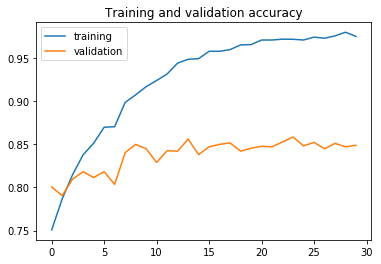

<Figure size 432x288 with 0 Axes>

In [28]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']



# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()



Text(0.5, 1.0, 'Training and validation loss')

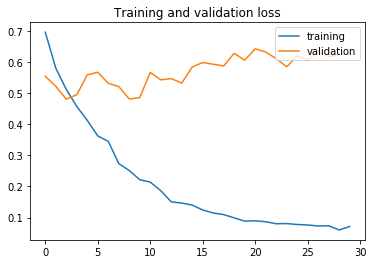

In [29]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')